# Garbage image classification

## Aggregating data, creating data set

We bring our folder images and we create a data frame.

In [200]:
import os
import pandas as pd

def list_folders_in_directory(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folders

directory_path = "./garbage-images/Garbage classification/Garbage classification"
folders_list = list_folders_in_directory(directory_path)
print(folders_list)


['paper', 'metal', 'glass']


In [201]:
data = []
for folder in folders_list: 
    files = os.listdir(os.path.join(directory_path, folder))
    #Add each file along with its folder name to the data list
    for file in files:
        data.append({'Folder': folder, 'File_name': file})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Display the DataFrame
df.head()



,Folder,File_name
0,paper,paper_1577.jpg
1,paper,paper_926.jpg
2,paper,paper_2718.jpg
3,paper,paper_1211.jpg
4,paper,paper_1205.jpg


## Analising the data

First we are checking our data set to see how manny photos we have.

In [202]:
df.shape

(10173, 2)

We want to check how manny images we have in each category.

In [203]:
df['Folder'].value_counts()

Folder
glass    4589
paper    3310
metal    2274
Name: count, dtype: int64

We have some inbalance data in 'trash'

We want to see what file format we have in the dataset.

We can see that we have only 'jpg' files.

In [204]:
# Extract extension using str.split and str.get
df['Extension'] = df['File_name'].str.split('.').str[-1]

df['Extension'].value_counts()

df.drop(df[df['Extension']=='DS_Store'].index , inplace=True)
df.head()

,Folder,File_name,Extension
0,paper,paper_1577.jpg,jpg
1,paper,paper_926.jpg,jpg
2,paper,paper_2718.jpg,jpg
3,paper,paper_1211.jpg,jpg
4,paper,paper_1205.jpg,jpg


We want to check the dimension of images.

We are adding the dimensions of the image into the dataframe with the help of Pillow library

In [205]:
from PIL import Image

def get_image_dimensions(df_row):
    file_path = os.path.join(directory_path, df_row['Folder'], df_row['File_name'])
    image = Image.open(file_path)
    width, height = image.size
    return width, height, image.format

df['Image_width'], df['Image_height'], df['Format'] = zip(*df.apply(get_image_dimensions, axis=1))

df.head()

,Folder,File_name,Extension,Image_width,Image_height,Format
0,paper,paper_1577.jpg,jpg,512,384,JPEG
1,paper,paper_926.jpg,jpg,512,384,JPEG
2,paper,paper_2718.jpg,jpg,183,275,JPEG
3,paper,paper_1211.jpg,jpg,512,384,JPEG
4,paper,paper_1205.jpg,jpg,800,874,JPEG


We are checking how many different values we are having in those two columns.

It seems that all the files have the same size. This means that we do not need to do any transformation to the size of the files.

In [206]:
df['Format'].value_counts()
formats = df[df['Format'] != "JPEG"]
formats.head(10)

,Folder,File_name,Extension,Image_width,Image_height,Format


In [207]:
print(df.Image_width.value_counts())
print(30*'*')
print(df.Image_height.value_counts())

Image_width
512     5930
225      688
474      570
259      121
475      106
        ... 
363        1
293        1
324        1
1002       1
938        1
Name: count, Length: 486, dtype: int64
******************************
Image_height
384     5930
225      824
355      123
194      120
631      112
        ... 
726        1
767        1
1374       1
1853       1
490        1
Name: count, Length: 617, dtype: int64


## Data processing

We need to load the data to normalise it, and split the data in training dataset and validation dataset.

In [211]:
import tensorflow as tf

# Define the directory containing your dataset
data_directory = "./garbage-images/Garbage classification/Garbage classification"

# Define image parameters

image_size = (250, 250)
batch_size = 32


# Create a TensorFlow Dataset object
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    labels="inferred",  # Labels are inferred from subfolder names
    label_mode="categorical",  # Use integer labels
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    labels="inferred",  # Labels are inferred from subfolder names
    label_mode="categorical",  # Use integer labels
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)




Found 10170 files belonging to 3 classes.
Using 8136 files for training.
Found 10170 files belonging to 3 classes.
Using 2034 files for validation.


Here we can see that we created a dataset with 3 classes

In [209]:
class_names = train_dataset.class_names
print("Class names:", class_names)


Class names: ['glass', 'metal', 'paper']


Data visualisation of 5 images from each class

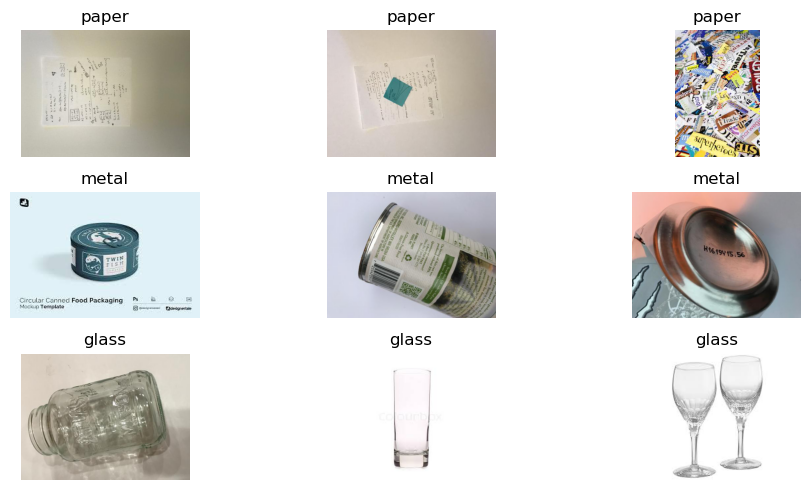

In [214]:
import os
import matplotlib.pyplot as plt
from PIL import Image

data_directory = "./garbage-images/Garbage classification/Garbage classification"

class_names = [name for name in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, name))]

plt.figure(figsize=(10, 5))

num_images_per_class = 3

for class_index, class_name in enumerate(class_names):
    class_images = []
    class_path = os.path.join(data_directory, class_name)
    for img_name in os.listdir(class_path)[:num_images_per_class]:
        if img_name != ".DS_Store":  # Skip non-directory files
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)
            class_images.append(image)
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name)
            plt.axis("off")

plt.tight_layout()
plt.show()


We take a look on what we have in train data set

In [215]:
for images, labels in train_dataset:
    print("Image batch shape:", images)
    print("Label batch shape:", labels)
    print("Label batch type:", labels.dtype)
    break  # Print only the first batch

Image batch shape: tf.Tensor(
[[[[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  [[255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   ...
   [255.       255.       255.      ]
   [255.       255.       255.      ]
   [255.       255.       255.      ]]

  ...

  [[224.32     237.32     243.32    ]
   [224.32     237.32     243.32    ]
   [224.32     237.32     243.32    ]
   ...
   [ 83.15759  196.17754  135.27258 ]
   [ 70.15498  188.64496  117.95396 ]
   [ 44.03481  170.07886   91.08879 ]]

  [[220.58804  

Now we need to normalise the data

In [210]:
normalization_layer = tf.keras.layers.Rescaling(scale = 1./255)

normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

for images, labels in normalized_train_dataset:
    print("Image batch shape after normalization:", images)
    print("Label batch shape after normalization:", labels)
    print("Label batch type:", labels.dtype)
    break  # Print only the first batch


Image batch shape after normalization: tf.Tensor(
[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[0.87968636 0.93066674 0.95419616]
   [0.87968636 0.93066674 0.95419616]
   [0.87968636 0.93066674 0.95419616]
   ...
   [0.32610822 0.7693237  0.53048074]
   [0.2751176  0.7397842  0.46256456]
   [0.17268553 0.666976   0.3572109

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                   rotation_range=15,zoom_range=0.1,
                                   width_shift_range=0.15,height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255.,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(data_directory, target_size=(250, 250), batch_size=32, class_mode="categorical", subset='training')
validation_generator = train_datagen.flow_from_directory(data_directory, target_size=(250, 250), batch_size=32,class_mode="categorical", subset='validation')

Found 1191 images belonging to 3 classes.


Found 296 images belonging to 3 classes.


## Define the model

Now that we have our data normalized we need to define the convolutional model


In [165]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Define the convolutional neural network architecture
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(250, 250, 3)),  # Input
    MaxPooling2D((2, 2)),
    Conv2D(32, 3, padding='same', activation='relu'),                             
    MaxPooling2D((2, 2)),
    Conv2D(64, 3, padding='same', activation='relu'),                             
    MaxPooling2D((2, 2)),
    Conv2D(128, 3, padding='same', activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),                                       
    Dense(3, activation='softmax')  # We have Dense 6 , because we have 6 classes of images
])


In [ ]:
# # Define the convolutional neural network architecture
# model = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.2),
#     Flatten(),
#     Dense(128, activation='relu'),                                      
#     Dense(3, activation='softmax')  
# ])

In [166]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


We can take a look on the model summary

In [107]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 31, 31, 64)      

We train the model

In [167]:
epochs = 10
history = model.fit(normalized_train_dataset, validation_data = normalized_val_dataset, epochs=epochs)

Epoch 1/10


255/255 [==============================] - 295s 1s/step - loss: 0.8922 - accuracy: 0.5935 - val_loss: 0.7829 - val_accuracy: 0.6519
Epoch 2/10
255/255 [==============================] - 293s 1s/step - loss: 0.5716 - accuracy: 0.7624 - val_loss: 0.3961 - val_accuracy: 0.8609
Epoch 3/10
255/255 [==============================] - 298s 1s/step - loss: 0.2962 - accuracy: 0.8934 - val_loss: 0.3018 - val_accuracy: 0.8997
Epoch 4/10
  1/255 [..............................] - ETA: 7:18 - loss: 0.2265 - accuracy: 0.9062

KeyboardInterrupt: 

Here we take a look on the model metrics on loss and accuracy

ValueError: x and y must have same first dimension, but have shapes (10,) and (15,)

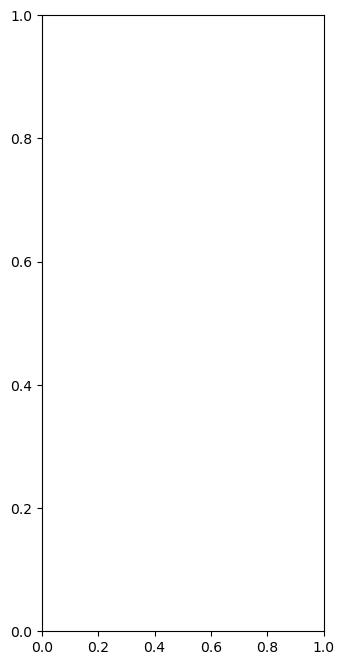

In [168]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [169]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(normalized_val_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

64/64 [==============================] - 16s 235ms/step - loss: 0.2915 - accuracy: 0.8977
Test Loss: 0.29151463508605957
Test Accuracy: 0.8977384567260742


Now that we are happy with our model accuracy we can save the model

In [127]:
model.save('first_model')

INFO:tensorflow:Assets written to: first_model/assets


INFO:tensorflow:Assets written to: first_model/assets


Now let's try to make a prediction with an image

Image loaded successfully as a TensorFlow tensor.
1/1 [==============================] - 0s 48ms/step


glass
0.99999547
[[9.9999547e-01 6.3528930e-08 4.3845939e-06]]


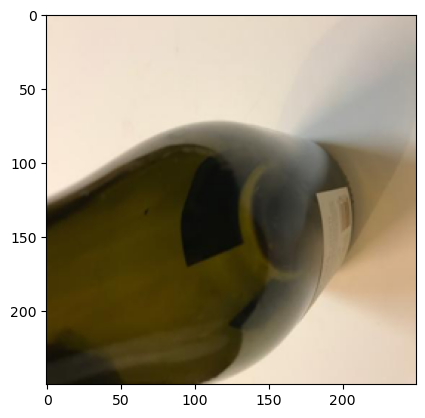

In [189]:
import numpy as np

image = Image.open('/Users/admin/proiecte/ai-garbage-image-classification/validation_images/glass/glass179.jpg')

# Resize the image to the desired size
image = image.resize((250, 250))  # Replace 'width' and 'height' with desired dimensions

# Convert the image to a numpy array
image_array = np.array(image)

# Convert the numpy array to a TensorFlow tensor
image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

# Expand the dimensions of the tensor to match the expected input shape
image_tensor = tf.expand_dims(image_tensor, axis=0)

print("Image loaded successfully as a TensorFlow tensor.")

predictions = model.predict(image_tensor)
predicted_index = np.argmax(predictions)
predicted_label = class_names[predicted_index]
print(predicted_label)
print(np.max(predictions))
plt.imshow(image)
print(predictions)



So we trained an tested the model and we noticed that our model is not performing well. We can observe that we have a good accuracy but our model does not perform well at predictions.
We will try to modify our images dimension to have the same aspect ratio with the kernel map.